## The Inspection Club

As you know, Python leverages polymorphism at its maximum by dealing only with generic references to objects. This makes OOP not an addition to the language but part of its structure from the ground up. Moreover, Python pushes the EAFP appoach, which tries to avoid direct inspection of objects as much as possible.

It is however very interesting to read what Guido van Rossum says in [PEP 3119](http://legacy.python.org/dev/peps/pep-3119/): _Invocation means interacting with an object by invoking its methods. Usually this is combined with polymorphism, so that invoking a given method may run different code depending on the type of an object. Inspection means the ability for external code (outside of the object's methods) to examine the type or properties of that object, and make decisions on how to treat that object based on that information. [...] In classical OOP theory, invocation is the preferred usage pattern, and inspection is actively discouraged, being considered a relic of an earlier, procedural programming style. However, in practice this view is simply too dogmatic and inflexible, and leads to a kind of design rigidity that is very much at odds with the dynamic nature of a language like Python._

The author of Python recognizes that forcing the use of a pure polymorphic approach leads sometimes to solutions that are too complex or even incorrect. In this section I want to show some of the problems that can arise from a pure polymorphic approach and introduce Abstract Base Classes, which aim to solve them. I strongly suggest to read [PEP 3119](http://legacy.python.org/dev/peps/pep-3119/) (as for any other PEP) since it contains a deeper and better explanation of the whole matter. Indeed I think that this PEP is so well written that any further explanation is hardly needed. I am however used to write explanations to check how much I understood about the topic, so I am going to try it this time too.

#### E.A.F.P the Extra Test Trial

The EAFP coding style requires you to trust the incoming objects to provide the attributes and methods you need, and to manage the possible exceptions, if you know how to do it. Sometimes, however, you need to test if the incoming object matches a complex behaviour. For example, you could be interested in testing if the object _acts_ like a list, but you quickly realize that the amount of methods a `list` provides is very big and this could lead to odd EAFP code like

``` python
try:
    obj.append
    obj.count
    obj.extend
    obj.index
    obj.insert
    [...]
except AttributeError:
    [...]
```

where the methods of the `list` type are accessed (not called) just to force the object to raise the `AttributeError` exception if they are not present. This code, however, is not only ugly but also wrong. If you recall the "Enter the Composition" section of the [third post](/blog/2014/08/20/python-3-oop-part-3-delegation-composition-and-inheritance) of this series, you know that in Python you can always customize the `__getattr__()` method, which is called whenever the requested attribute is not found in the object. So I could write a class that passes the test but actually does not act like a list

``` python
class FakeList:
    def fakemethod(self):
        pass
    
    def __getattr__(self, name):
        if name in ['append', 'count', 'extend', 'index', 'insert', ...]:
            return self.fakemethod
```

This is obviously just an example, and no one will ever write such a class, but this demonstrates that just accessing methods does not guarantee that a class _acts_ like the one we are expecting.

There are many examples that could be done leveraging the highly dynamic nature of Python and its rich object model. I would summarize them by saying that sometimes you'd better to check the type of the incoming object.

In Python you can obtain the type of an object using the `type()` built-in function, but to check it you'd better use `isinstance()`, which returns a boolean value. Let us see an example before moving on

In [13]:
isinstance([], list)

True

In [14]:
isinstance(1, int)

True

In [15]:
class Door:
    pass

d = Door()
isinstance(d, Door)

True

In [16]:
class EnhancedDoor(Door):
    pass

ed = EnhancedDoor()
isinstance(ed, EnhancedDoor)

True

In [17]:
isinstance(ed, Door)

True

As you can see the function can also walk the class hierarchy, so the check is not so trivial like the one you would obtain by directly using `type()`.

The `isinstance()` function, however, does not completely solve the problem. If we write a class that actually _acts_ like a `list` but does not inherit from it, `isinstance()` does not recognize the fact that the two may be considered the same thing. The following code returns `False` regardless the content of the `MyList` class

In [18]:
class MyList:
    pass

ml = MyList()
isinstance(ml, list)

False

since `isinstance()` does not check the content of the class or its behaviour, it just consider the class and its ancestors.

The problem, thus, may be summed up with the following question: what is the best way to test that an object exposes a given interface? Here, the word _interface_ is used for its natural meaning, without any reference to other programming solutions, which however address the same problem.

A good way to address the problem could be to write inside an attribute of the object the list of interfaces it promises to implement, and to agree that any time we want to test the behaviour of an object we simply have to check the content of this attribute. This is exactly the path followed by Python, and it is very important to understand that the whole system is just about a promised behaviour.

The solution proposed through PEP 3119 is, in my opinion, very simple and elegant, and it perfectly fits the nature of Python, where things are usually agreed rather than being enforced. Not only, the solution follows the spirit of polymorphism, where information is provided by the object itself and not extracted by the calling code.

In the next sections I am going to try and describe this solution in its main building blocks. The matter is complex so my explanation will lack some details: please refer to the forementioned PEP 3119 for a complete description.

#### Who Framed the Metaclasses

As already described, Python provides two built-ins to inspect objects and classes, which are `isinstance()` and `issubclass()` and it would be desirable that a solution to the inspection problem allows the programmer to go on with using those two functions.

This means that we need to find a way to inject the "behaviour promise" into both classes and instances. This is the reason why metaclasses come in play. Recall what we said about them in the fifth issue of this series: metaclasses are the classes used to build classes, which means that they are the preferred way to change the structure of a class, and, in consequence, of its instances.

Another way to do the same job would be to leverage the inheritance mechanism, injecting the behaviour through a dedicated parent class. This solution has many downsides, which I'm am not going to detail. It is enough to say that affecting the class hierarchy may lead to complex situations or subtle bugs. Metaclasses may provide here a different entry point for the introduction of a "virtual base class" (as PEP 3119 specifies, this is not the same concept as in C++).

#### Overriding Places

As said, `isinstance()` and `issubclass()` are built-in functions, not object methods, so we cannot simply override them providing a different implementation in a given class. So the first part of the solution is to change the behaviour of those two functions to first check if the class or the instance contain a special method, which is `__instancecheck__()` for `isinstance()` and `__subclasscheck__()` for `issubclass()`. So both built-ins try to run the respective special method, reverting to the standard algorithm if it is not present.

A note about naming. Methods must accept the object they belong to as the first argument, so the two special methods shall have the form

``` python
def __instancecheck__(cls, inst):
   [...]
   
def __subclasscheck__(cls, sub):
   [...]
```

where `cls` is the class where they are injected, that is the one representing the promised behaviour. The two built-ins, however, have a reversed argument order, where the behaviour comes after the tested object: when you write `isinstance([], list)` you want to check if the `[]` instance has the `list` behaviour. This is the reason behind the name choice: just calling the methods `__isinstance__()` and `__issubclass__()` and passing arguments in a reversed order would have been confusing.

#### This is ABC

The proposed solution is thus called Abstract Base Classes, as it provides a way to attach to a concrete class a virtual class with the only purpose of signaling a promised behaviour to anyone inspecting it with `isinstance()` or `issubclass()`.

To help programmers implement Abstract Base Classes, the standard library has been given an `abc` module, thet contains the `ABCMeta` class (and other facilities). This class is the one that implements `__instancecheck__()` and `__subclasscheck__()` and shall be used as a metaclass to augment a standard class. This latter will then be able to register other classes as implementation of its behaviour.

Sounds complex? An example may clarify the whole matter. The one from the official documentation is rather simple:

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
type(KNeighborsClassifier)   ##

abc.ABCMeta

In [5]:
import inspect

In [7]:
print(inspect.getsource(KNeighborsClassifier)) ## 대문자-- 대문자 클래스

class KNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                           SupervisedIntegerMixin, ClassifierMixin):
    """Classifier implementing the k-nearest neighbors vote.

    Read more in the :ref:`User Guide <classification>`.

    Parameters
    ----------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for :meth:`kneighbors` queries.

    weights : str or callable, optional (default = 'uniform')
        weight function used in prediction.  Possible values:

        - 'uniform' : uniform weights.  All points in each neighborhood
          are weighted equally.
        - 'distance' : weight points by the inverse of their distance.
          in this case, closer neighbors of a query point will have a
          greater influence than neighbors which are further away.
        - [callable] : a user-defined function which accepts an
          array of distances, and returns an array of the same shape
          containing the we

In [9]:
from sklearn.datasets import load_boston ## ~~_~~ 함수

In [10]:
load_boston()

{'DESCR': "Boston House Prices dataset\n===========================\n\nNotes\n------\nData Set Characteristics:  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive\n    \n    :Median Value (attribute 14) is usually the target\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per

In [11]:
import matplotlib.pyplot as plt

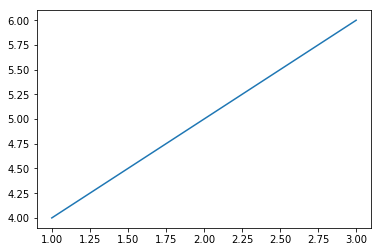

In [13]:
plt.plot([1,2,3],[4,5,6])

In [15]:
## 아이디어 빨리하면할수록 좋다
## 자습서부터 복습
## 다음주부터 lms에 숙제 적혀있음(기간은 없지만 ~8.31까지)


In [ ]:
## Notimplemented  추상클래스 실제에서 구현 안하면 이런 에러 메세지 나온다

In [1]:
from abc import ABCMeta  ## 싸이킷수업 ABCMeta   ABC -> 추상클래스 추상단계에서는 구현 안해도 되지만 실제 단계에서는 구현하도록 강제
                        ## 이럴때 쓰는게 METACLASS -> ABCMeta 쓴다 이거쓰면 된다., 우리는 추상 클래스 안쓴다. 현재 레벨에서는 남이 만든 구체적인거 씀
                        ## ABCMeta, ABC class의 메타 클래스
                        ## 기계학습쓸대 싸이킷씀
class MyABC(metaclass=ABCMeta):
    pass

MyABC.register(tuple)

assert issubclass(tuple, MyABC)
assert isinstance((), MyABC)

Here, the `MyABC` class is provided the `ABCMeta` metaclass. This puts the two `__isinstancecheck__()` and `__subclasscheck__()` methods inside `MyABC` so that, when issuing `isinstance()`, what Python actually ececutes is

In [ ]:
# 객체중   NotImplemented 

In [14]:
...  ## Ellipsis 객체

Ellipsis

In [20]:
d = {'a': 1}
isinstance(d, MyABC)

False

In [21]:
MyABC.__class__.__instancecheck__(MyABC, d)

False

In [22]:
isinstance((), MyABC)

True

In [23]:
MyABC.__class__.__instancecheck__(MyABC, ())

True

After the definition of `MyABC` we need a way to signal that a given class is an instance of the Abstract Base Class and this happens through the `register()` method, provided by the `ABCMeta` metaclass. Calling `MyABC.register(tuple)` we record inside `MyABC` the fact that the `tuple` class shall be identified as a subclass of `MyABC` itself. This is analogous to saying that `tuple` inherits from `MyABC` but not quite the same. As already said registering a class in an Abstract Base Class with `register()` does not affect the class hierarchy. Indeed, the whole `tuple` class is unchanged.

The current implementation of ABCs stores the registered types inside the `_abc_registry` attribute. Actually it stores there weak references to the registered types (this part is outside the scope of this article, so I'm not detailing it)

In [24]:
MyABC._abc_registry.data

{<weakref at 0xb6325f2c; to 'type' at 0x83dcca0 (tuple)>}

## Movie Trivia

Section titles come from the following movies: _The Breakfast Club (1985)_, _E.T. the Extra-Terrestrial (1982)_, _Who Framed Roger Rabbit (1988)_, _Trading Places (1983)_, _This is Spinal Tap (1984)_.

## Sources

You will find a lot of documentation in [this Reddit post](http://www.reddit.com/r/Python/comments/226ahl/some_links_about_python_oop/). Most of the information contained in this series come from those sources.

## Feedback

Feel free to use [the blog Google+ page](https://plus.google.com/u/0/b/110554719587236016835/110554719587236016835/posts) to comment the post. The [GitHub issues](https://github.com/lgiordani/lgiordani.github.com/issues) page is the best place to submit corrections.